This is just for starting the python script. No need to include it in the code

In [1]:
# Import the modules and packages we will use
import json
import os
from datetime import datetime
from pathlib import Path

import dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import patsy

%load_ext blackcellmagic


plt.style.use(['science', 'nature'])
dotenv.load_dotenv()
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

Here we are configuring the script

In [2]:
# Define GLOBAL variables

# Set the airport of interest to ORD (O'Hare International Airport)
AIRPORT_OF_INTEREST = "ORD"

#### PATHS AND DIRECTORIES
ROOT = Path(".")  # root path (the directory of the project folder)

# Where to store the input data
DATA_FOLDER = "data"
RAW_DATA_FOLDER = "raw"
RAW_FLIGHTS_DATA_FOLDER = "flights"
PROCESSED_DATA_FOLDER = "processed"
OUTPUT_DATA_FOLDER = "output"

DATA_PATH = ROOT / DATA_FOLDER

if not Path.exists(DATA_PATH):
    raise FileNotFoundError(f"The data folder does not exist: {DATA_PATH}")

RAW_DATA_PATH = DATA_PATH / RAW_DATA_FOLDER

if not Path.exists(RAW_DATA_PATH):
    raise FileNotFoundError(f"The raw data folder does not exist: {RAW_DATA_PATH}")

RAW_FLIGHTS_DATA_PATH = DATA_PATH / RAW_DATA_FOLDER / RAW_FLIGHTS_DATA_FOLDER

if not Path.exists(RAW_FLIGHTS_DATA_PATH):
    raise FileNotFoundError(
        f"The raw flights data folder does not exist: {RAW_FLIGHT_DATA_PATH}"
    )

PROCESSED_DATA_PATH = DATA_PATH / PROCESSED_DATA_FOLDER
Path.mkdir(PROCESSED_DATA_PATH, parents=True, exist_ok=True)

OUTPUT_DATA_PATH = DATA_PATH / OUTPUT_DATA_FOLDER
Path.mkdir(OUTPUT_DATA_PATH, parents=True, exist_ok=True)

# Name of the HDF5 file containing the data
HDF5_FILE = "flight_data.h5"

# Name of the CSV file containing the airport codes
AIRPORT_CODES_FILE = "airport_codes.csv"

# Name of the JSON file containing the weather daata
WEATHER_FILE = "ORD-weather-2009-2018.json"

##  1. Process the flight data

The data we downloaded from [“Airline Delay and Cancellation Data 2009 - 2018” Kaggle dataset](https://www.kaggle.com/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018). It is in the folder `data/raw/flights` separated by year. It includes all the flights.

We need only the flights departing from Chicago Ohare (ORD), so we join (concatenate) all the csv folders into one big dataframe, and then filter the dataframe to only include flights departing from Chicago Ohare (ORD).

In [3]:
def process_flight_data(
    raw_flights_data_path: Path = RAW_FLIGHTS_DATA_PATH,
    processed_data_path: Path = PROCESSED_DATA_PATH,
    hdf5_file: str = HDF5_FILE, key=f"ORIGIN:{AIRPORT_OF_INTEREST}"
):
    
    def load_csv_files(files: list) -> pd.DataFrame:
        li = []  # where to store each csv file as a dataframe
        for filename in csv_files.__iter__():
            df = pd.read_csv(filename, index_col=None, header=0)
            li.append(df)
        return pd.concat(li, axis=0, ignore_index=True)

    # Try to load the HDF5 file
    try:
        df = pd.read_hdf(processed_data_path / hdf5_file, key=key)
    except (FileNotFoundError, KeyError): # if it does not exist, or key is wrong, create it
        # Get all the CSV Files
        csv_files = sorted(raw_flights_data_path.glob("*.csv"))
        
        print(f"Loading files, this may take a while...")
        df = load_csv_files(csv_files)
        
        # filter the dataframe
        df = df[df["ORIGIN"] == AIRPORT_OF_INTEREST]
        # save dataframe to HDF5 file
        df.to_hdf(processed_data_path / hdf5_file, key=key, mode="w", index=False)
    
    return df.reset_index(drop=True) # return the dataframe

df_flights = process_flight_data()

print("Dataframe loaded and filtered, lets look at the first rows to understand what we are doing")
df_flights.head()

Dataframe loaded and filtered, lets look at the first rows to understand what we are doing


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2009-01-01,XE,1232,ORD,EWR,905.0,900.0,-5.0,16.0,916.0,...,127.0,110.0,88.0,719.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-01,XE,1234,ORD,EWR,1230.0,1234.0,4.0,8.0,1242.0,...,149.0,111.0,89.0,719.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-01,XE,1236,ORD,EWR,1630.0,1619.0,-11.0,19.0,1638.0,...,152.0,142.0,88.0,719.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-01,XE,2647,ORD,IAH,1205.0,1154.0,-11.0,15.0,1209.0,...,180.0,163.0,142.0,925.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-01,XE,2865,ORD,IAH,1500.0,1453.0,-7.0,11.0,1504.0,...,174.0,159.0,136.0,925.0,NaN,NaN,NaN,NaN,NaN,NaN


Let's look at the data columns we have

In [4]:
df_flights.columns

Index(['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 27'],
      dtype='object')

in prettier format:

|         Name        |                                                 Description                                                |   Type(Format)  |   Example  |
|:-------------------:|:----------------------------------------------------------------------------------------------------------:|:---------------:|:----------:|
|       FL_DATE       |                                             Date of the flight                                             | DATE (yy/mm/dd) | 2009-05-02 |
|      OP_CARRIER     |                                             Airline Identifier                                             |      STRING     |     9E     |
|  OP_CARRIER_FL_NUM  |                                                Flight Number                                               |     INTEGER     |    2216    |
|        ORIGIN       |                                      Starting Airport Code (IATA Code)                                     |      STRING     |     MLI    |
|         DEST        |                                    Destination Airport Code (IATA Code)                                    |      STRING     |     MEM    |
|     CRS_DEP_TIME    |                                           Planned Departure Time                                           |     INTEGER     |     600    |
|       DEP_TIME      |                                            Actual Departure Time                                           |      FLOAT      |    603.0   |
|      DEP_DELAY      |                                     Total Delay on Departure in minutes                                    |      FLOAT      |     3.0    |
|       TAXI_OUT      |           The time duration elapsed between departure from the origin airport gate and wheels off          |      FLOAT      |    14.0    |
|      WHEELS_OFF     |                         The time point that the aircraft’s wheels leave the ground                         |      FLOAT      |    617.0   |
|      WHEELS_ON      |                        The time point that the aircraft’s wheels touch on the ground                       |      FLOAT      |    757.0   |
|       TAXI_IN       |           The time duration elapsed between wheels-on and gate arrival at the destination airport          |      FLOAT      |     8.0    |
|     CRS_ARR_TIME    |                                            Planned arrival time                                            |     INTEGER     |     732    |
|       ARR_TIME      |                                             Actual Arrival Time                                            |      FLOAT      |    805.0   |
|      ARR_DELAY      |                                      Total Delay on Arrival in minutes                                     |      FLOAT      |    33.0    |
|      CANCELLED      |                                      Flight Cancelled (1 = cancelled)                                      |      FLOAT      |     0.0    |

## We need to get the weather data

[The data comes from VisualCrossing](https://visualcrossing.com/account).We have a file in `data/raw/` called `ORD-weather-2009-2018.json` which contains the weather data for Chicago Ohare (ORD) for all the years 2009-2018.

In [5]:
def process_weather_data(
    raw_weather_data: Path = RAW_DATA_PATH / WEATHER_FILE,
    processed_data_path: Path = PROCESSED_DATA_PATH,
    hdf5_file: str = "ord_weather.h5",
    key=f"WEATHER:{AIRPORT_OF_INTEREST}",
):
    def load_json_file(files: list) -> pd.DataFrame:
        data = json.load(open(raw_weather_data))

        li = []  # where to store each csv file as a dataframe

        for day in data["days"]:
            df = pd.DataFrame(day["hours"])
            # do some transformations
            df.rename(
                columns={"datetime": "time", "datetimeEpoch": "date"}, inplace=True
            )

            df["date"] = df["date"].apply(
                lambda x: (pd.to_datetime(datetime.fromtimestamp(x)))
            )
            df["date"] = df["date"].dt.date
            li.append(df)

        return pd.concat(li, axis=0, ignore_index=True)

    # Try to load the HDF5 file
    try:
        df = pd.read_hdf(processed_data_path / hdf5_file, key=key)
    except (
        FileNotFoundError,
        KeyError,
    ):  # if it does not exist, or key is wrong, create it
        # Get all the CSV Files

        print(f"Loading files, this may take a while...")
        df = load_json_file(RAW_DATA_PATH / WEATHER_FILE)

        # save dataframe to HDF5 file
        df.to_hdf(processed_data_path / hdf5_file, key=key, mode="w", index=False)

    return df  # return the dataframe


df_weather = process_weather_data()

Lets look at how the data looks

In [6]:
df_weather.head()

,time,date,temp,feelslike,humidity,dew,precip,precipprob,snow,snowdepth,...,visibility,cloudcover,solarradiation,solarenergy,uvindex,conditions,icon,stations,source,tzoffset
0,00:00:00,2009-01-01,-8.3,-13.6,66.89,-13.4,0.0,None,None,None,...,16.0,88.0,None,None,0.0,Partially cloudy,partly-cloudy-night,"[72534014819, 72530094846, 74466504838]",obs,NaN
1,01:00:00,2009-01-01,-8.2,-14.7,66.58,-13.4,0.0,None,None,None,...,16.0,88.0,None,None,0.0,Partially cloudy,partly-cloudy-night,"[72534014819, 72530094846, 74466504838]",obs,NaN
2,02:00:00,2009-01-01,-7.8,-14.6,66.38,-13.0,0.0,None,None,None,...,16.0,91.6,None,None,0.0,Overcast,cloudy,"[72534014819, 72530094846, 74466504838]",obs,NaN
3,03:00:00,2009-01-01,-7.1,-14.3,67.03,-12.2,0.0,None,None,None,...,16.0,100.0,None,None,0.0,Overcast,cloudy,"[72534014819, 72530094846, 74466504838]",obs,NaN
4,04:00:00,2009-01-01,-7.1,-13.9,69.46,-11.8,0.0,None,None,None,...,16.0,100.0,None,None,0.0,Overcast,cloudy,"[72534014819, 72530094846, 74466504838]",obs,NaN


This are the columns of data we have

In [7]:
df_weather.columns

Index(['time', 'date', 'temp', 'feelslike', 'humidity', 'dew', 'precip',
       'precipprob', 'snow', 'snowdepth', 'preciptype', 'windgust',
       'windspeed', 'winddir', 'pressure', 'visibility', 'cloudcover',
       'solarradiation', 'solarenergy', 'uvindex', 'conditions', 'icon',
       'stations', 'source', 'tzoffset'],
      dtype='object')

A summary of the data

In [8]:
df_weather.describe()

,temp,feelslike,humidity,dew,precip,windspeed,winddir,pressure,visibility,cloudcover,uvindex,tzoffset
count,87648.000000,87648.000000,87648.000000,87648.000000,87641.000000,87648.000000,87310.000000,87647.000000,87648.000000,87648.000000,87648.0,57110.0
mean,10.600452,8.706654,67.513745,4.273025,0.114299,15.209802,187.244348,1016.451836,14.617897,65.547010,0.0,-5.0
std,11.541020,13.909802,16.995718,10.723695,0.837129,8.406331,108.078392,7.525111,3.335163,35.153918,0.0,0.0
min,-27.100000,-41.000000,13.610000,-32.800000,0.000000,0.000000,0.000000,979.500000,0.000000,0.000000,0.0,-5.0
25%,1.700000,-2.100000,55.520000,-3.200000,0.000000,9.300000,83.000000,1011.800000,15.800000,28.400000,0.0,-5.0
50%,11.000000,11.000000,68.820000,4.500000,0.000000,14.400000,203.000000,1016.300000,16.000000,81.800000,0.0,-5.0
75%,20.100000,20.100000,80.830000,13.100000,0.000000,20.400000,278.000000,1021.100000,16.000000,99.400000,0.0,-5.0
max,39.100000,43.300000,100.000000,26.000000,72.830000,64.800000,360.000000,1043.900000,17.900000,100.000000,0.0,-5.0


## Now we need to merge the data.

But first we need to process the flights df and weather df to match the time and dates when joining

In [9]:
df_flights.columns

Index(['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 27'],
      dtype='object')

Looking at the data, the time columns on `df_flighs` like `CRS_DEP_TIME` and `DEP_TIME` are in the complete time format HHMM, while the weather data has one datapoint at each hour HH:00. What we are going to do is create new columns rounding up the time columns on `df_flights` to the floor hour (trim hour) and then merge the two dataframes.

The modified time columns will have the suffix `_hour`

`df_flights`

In [10]:
df_flight_time_cols = ["CRS_DEP_TIME", "DEP_TIME", "CRS_ARR_TIME", "ARR_TIME"]

for col in df_flight_time_cols:
    print("Working on column:", col)
    df_flights[col] = df_flights[col].fillna(0)
    col_and_suffix = col + "_hour"
    df_flights[col_and_suffix] = (df_flights[col] / 100).astype(int)


# duplicate some columns and rename to match the weather df
df_flights["date"] = pd.to_datetime(df_flights["FL_DATE"]).dt.date
df_flights["time_hour"] = df_flights.CRS_DEP_TIME_hour

Working on column: CRS_DEP_TIME
Working on column: DEP_TIME
Working on column: CRS_ARR_TIME
Working on column: ARR_TIME


`df_weather`

In [11]:
df_weather['time_hour'] = pd.to_datetime(df_weather['time']).dt.strftime('%H').astype(int)

Merge the dataframes

In [12]:
df = pd.merge(df_flights, df_weather, on=['date', 'time_hour'])

Let's look at the columns

In [13]:
df.columns

Index(['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 27', 'CRS_DEP_TIME_hour', 'DEP_TIME_hour',
       'CRS_ARR_TIME_hour', 'ARR_TIME_hour', 'date', 'time_hour', 'time',
       'temp', 'feelslike', 'humidity', 'dew', 'precip', 'precipprob', 'snow',
       'snowdepth', 'preciptype', 'windgust', 'windspeed', 'winddir',
       'pressure', 'visibility', 'cloudcover', 'solarradiation', 'solarenergy',
       'uvindex', 'conditions', 'icon', 'stations', 'source', 'tzoffset'],
      dtype='object')

So there's a few columns that we don't need or are duplicated.

The ones we need to remove are:
- `FL_DATE` - we already have `date` column
- `ORIGIN` - they all are coming out of ORD
- `WHEELS_ON`, `WHEELS_OFF`, `TAXI_IN`, `CRS_ARR_TIME`, `ARR_TIME`, `ARR_DELAY` - this happen after the even of delay
- The types of delay: `SECURITY_DELAY`, etc...
- `Unnamed: 27`, `ACTUAL_ELAPSED_TIME`, `AIR_TIME`, `DISTANCE`, `CRS_ARR_TIME_hour`, `ARR_TIME_hour`, `CANCELLATION_CODE`, `DIVERTED`, `CRS_ELAPSED_TIME` - there are not useful or we already discarded them
- `solarradiation`, `solarenergy`, `uvindex`, `icon`, `stations`, `source`, `conditions`, `tzoffset`
- `precipprob`, `snow`, `snowdepth`, `preciptype`, `windgust` -> this have little data

In [14]:
df_cleaned = df.copy(deep=True)
df_cleaned = df_cleaned.drop(
    [
        "FL_DATE",
        "ORIGIN",
        "WHEELS_ON",
        "WHEELS_OFF",
        "TAXI_IN",
        "TAXI_OUT",
        "CARRIER_DELAY",
        "CANCELLATION_CODE",
        "CRS_ARR_TIME",
        "ARR_TIME",
        "ARR_DELAY",
        "SECURITY_DELAY",
        "CRS_ELAPSED_TIME",
        "WEATHER_DELAY",
        "NAS_DELAY",
        "LATE_AIRCRAFT_DELAY",
        "Unnamed: 27",
        "ACTUAL_ELAPSED_TIME",
        "AIR_TIME",
        "DISTANCE",
        "CRS_ARR_TIME_hour",
        "DIVERTED",
        "ARR_TIME_hour",
        "solarradiation",
        "solarenergy",
        "uvindex",
        "icon",
        "stations",
        "source",
        "conditions",
        "tzoffset",
        "precipprob",
        "snow",
        "snowdepth",
        "preciptype",
        "windgust",
        "OP_CARRIER_FL_NUM"
    ],
    axis=1,
)

del df, df_flights, df_weather  # delete the dataframes to free up memory

df_cleaned.head()

,OP_CARRIER,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CANCELLED,CRS_DEP_TIME_hour,DEP_TIME_hour,date,time_hour,...,temp,feelslike,humidity,dew,precip,windspeed,winddir,pressure,visibility,cloudcover
0,XE,EWR,905.0,900.0,-5.0,0.0,9,9,2009-01-01,9,...,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
1,YV,CHS,910.0,905.0,-5.0,0.0,9,9,2009-01-01,9,...,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
2,YV,COS,941.0,939.0,-2.0,0.0,9,9,2009-01-01,9,...,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
3,YV,ORF,920.0,925.0,5.0,0.0,9,9,2009-01-01,9,...,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
4,OH,CVG,925.0,925.0,0.0,0.0,9,9,2009-01-01,9,...,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2


- Create a column `DELAYED` if delay is greater than 0
- Create a column `DELAYED_20` if delay is greater than 20


In [15]:
df_cleaned['DELAYED'] = (df_cleaned['DEP_DELAY'] > 0).astype(int)
df_cleaned['DELAYED_20'] = (df_cleaned['DEP_DELAY'] >= 20).astype(int)

rearrange the columns. Remove `DEP_TIME` because we already have `DELAYED` and `DELAYED_20`

In [16]:
df_cleaned.columns

df_cleaned = df_cleaned[
    [
        "CANCELLED",
        "DELAYED",
        "DELAYED_20",
        "DEP_DELAY",
        "CRS_DEP_TIME",
        "date",
        "time",
        "OP_CARRIER",
        "DEST",        
        "temp",
        "feelslike",
        "humidity",
        "dew",
        "precip",
        "windspeed",
        "winddir",
        "pressure",
        "visibility",
        "cloudcover",
    ]
]


# modify the type of cancelled
df_cleaned.CANCELLED = df_cleaned.CANCELLED.astype(int)

df_cleaned.head()

,CANCELLED,DELAYED,DELAYED_20,DEP_DELAY,CRS_DEP_TIME,date,time,OP_CARRIER,DEST,temp,feelslike,humidity,dew,precip,windspeed,winddir,pressure,visibility,cloudcover
0,0,0,0,-5.0,905.0,2009-01-01,09:00:00,XE,EWR,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
1,0,0,0,-5.0,910.0,2009-01-01,09:00:00,YV,CHS,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
2,0,0,0,-2.0,941.0,2009-01-01,09:00:00,YV,COS,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
3,0,1,0,5.0,920.0,2009-01-01,09:00:00,YV,ORF,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
4,0,0,0,0.0,925.0,2009-01-01,09:00:00,OH,CVG,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2


for the date, add a column `day`, `month`, `weekday`, `quarter`, `is_holiday`, `is_weekend`

In [17]:
# set up type
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])

# set up for holiday calendar
cal = calendar()
holidays = cal.holidays(start=df_cleaned['date'].min(), end=df_cleaned['date'].max())


df_cleaned['month'] = df_cleaned['date'].dt.month
df_cleaned['weekday'] = df_cleaned['date'].dt.dayofweek + 1
df_cleaned['quarter'] = df_cleaned['date'].dt.quarter
df_cleaned['is_holiday'] = df_cleaned['date'].isin(holidays).astype(int)
df_cleaned['is_weekend'] = (df_cleaned['weekday'] > 5).astype(int)

### theres a few outliers precip so lets remove them

In [18]:

df_cleaned = df_cleaned[df_cleaned.precip < 30]

Finally, drop the date and time column


In [19]:
df_cleaned.drop(['date', 'time'], axis=1, inplace=True)

# FINALLY we can start the analysis

## Remember, we are focusing on prediction, not on inference on this analysis

### I'm also saving a sample of the dataframe as an excel file so you can open it in case you have any issues

In [20]:
df_cleaned.sample(10000).to_excel(OUTPUT_DATA_PATH / 'cleaned_data.xlsx', index=False)

We will standardize the columns in the form z = (x - mean) / std
The columns will be `temp`, `feelslike`, `dewpoint`, `windspeed`, `visibility`, `pressure`, `cloudcover`, `humidity`, `precipitation`, `winddir`


In [21]:
from sklearn import preprocessing

df_norm = df_cleaned.copy(deep=True)
def normalize_colum(df, col):
    x = df[col].values #returns a numpy array
    min_max_scaler = preprocessing.StandardScaler()
    x = x.reshape(-1, 1)
    x_scaled = min_max_scaler.fit_transform(x)
    return x_scaled

for col in ['temp', 'feelslike', 'humidity', 'dew', 'precip', 'windspeed', 'winddir', 'pressure', 'visibility', 'cloudcover']:
    df_norm[col] = normalize_colum(df_norm, col)

In [22]:
df_norm.head()

,CANCELLED,DELAYED,DELAYED_20,DEP_DELAY,CRS_DEP_TIME,OP_CARRIER,DEST,temp,feelslike,humidity,...,windspeed,winddir,pressure,visibility,cloudcover,month,weekday,quarter,is_holiday,is_weekend
0,0,0,0,-5.0,905.0,XE,EWR,-1.511828,-1.684872,0.21766,...,1.270263,0.040878,0.584519,0.399819,0.586816,1,4,1,1,0
1,0,0,0,-5.0,910.0,YV,CHS,-1.511828,-1.684872,0.21766,...,1.270263,0.040878,0.584519,0.399819,0.586816,1,4,1,1,0
2,0,0,0,-2.0,941.0,YV,COS,-1.511828,-1.684872,0.21766,...,1.270263,0.040878,0.584519,0.399819,0.586816,1,4,1,1,0
3,0,1,0,5.0,920.0,YV,ORF,-1.511828,-1.684872,0.21766,...,1.270263,0.040878,0.584519,0.399819,0.586816,1,4,1,1,0
4,0,0,0,0.0,925.0,OH,CVG,-1.511828,-1.684872,0.21766,...,1.270263,0.040878,0.584519,0.399819,0.586816,1,4,1,1,0


## Test / Split Data

Test = 30%
Train = 70% 


In [23]:
test_size = 0.3
train_size = 1 - test_size

rng = np.random.default_rng(42)

train_ix = rng.choice(df_norm.index, size=int(df_norm.shape[0]*train_size), replace=False)
test_ix = np.setdiff1d(df_norm.index, train_ix)

we first set up different Y, for different predictions. Then drop them from 

In [24]:
Y_delayed = df_norm['DELAYED']
Y_delay_time = df_norm['DEP_DELAY'].fillna(0)
Y_delayed_20 = df_norm['DELAYED_20']
Y_cancelled = df_norm['CANCELLED']

Y_delayed_train = Y_delayed.loc[train_ix]
Y_delayed_test = Y_delayed.loc[test_ix]
Y_delay_time_train = Y_delay_time.loc[train_ix]
Y_delay_time_test = Y_delay_time.loc[test_ix]
Y_delayed_20_train = Y_delayed_20.loc[train_ix]
Y_delayed_20_test = Y_delayed_20.loc[test_ix]
Y_cancelled_train = Y_cancelled.loc[train_ix]
Y_cancelled_test = Y_cancelled.loc[test_ix]


Let's make a dataframe with all the potential independent variables without the Y variables we set above

In [25]:
X = df_norm.drop(['DELAYED', 'DELAYED_20', 'CANCELLED', 'DEP_DELAY'], axis=1)
# there are some empty values on windidir, so we will fill them with 0
X.fillna(0, inplace=True)

X_train = X.loc[train_ix]
X_test = X.loc[test_ix]
X.head()

,CRS_DEP_TIME,OP_CARRIER,DEST,temp,feelslike,humidity,dew,precip,windspeed,winddir,pressure,visibility,cloudcover,month,weekday,quarter,is_holiday,is_weekend
0,905.0,XE,EWR,-1.511828,-1.684872,0.21766,-1.449729,-0.147997,1.270263,0.040878,0.584519,0.399819,0.586816,1,4,1,1,0
1,910.0,YV,CHS,-1.511828,-1.684872,0.21766,-1.449729,-0.147997,1.270263,0.040878,0.584519,0.399819,0.586816,1,4,1,1,0
2,941.0,YV,COS,-1.511828,-1.684872,0.21766,-1.449729,-0.147997,1.270263,0.040878,0.584519,0.399819,0.586816,1,4,1,1,0
3,920.0,YV,ORF,-1.511828,-1.684872,0.21766,-1.449729,-0.147997,1.270263,0.040878,0.584519,0.399819,0.586816,1,4,1,1,0
4,925.0,OH,CVG,-1.511828,-1.684872,0.21766,-1.449729,-0.147997,1.270263,0.040878,0.584519,0.399819,0.586816,1,4,1,1,0


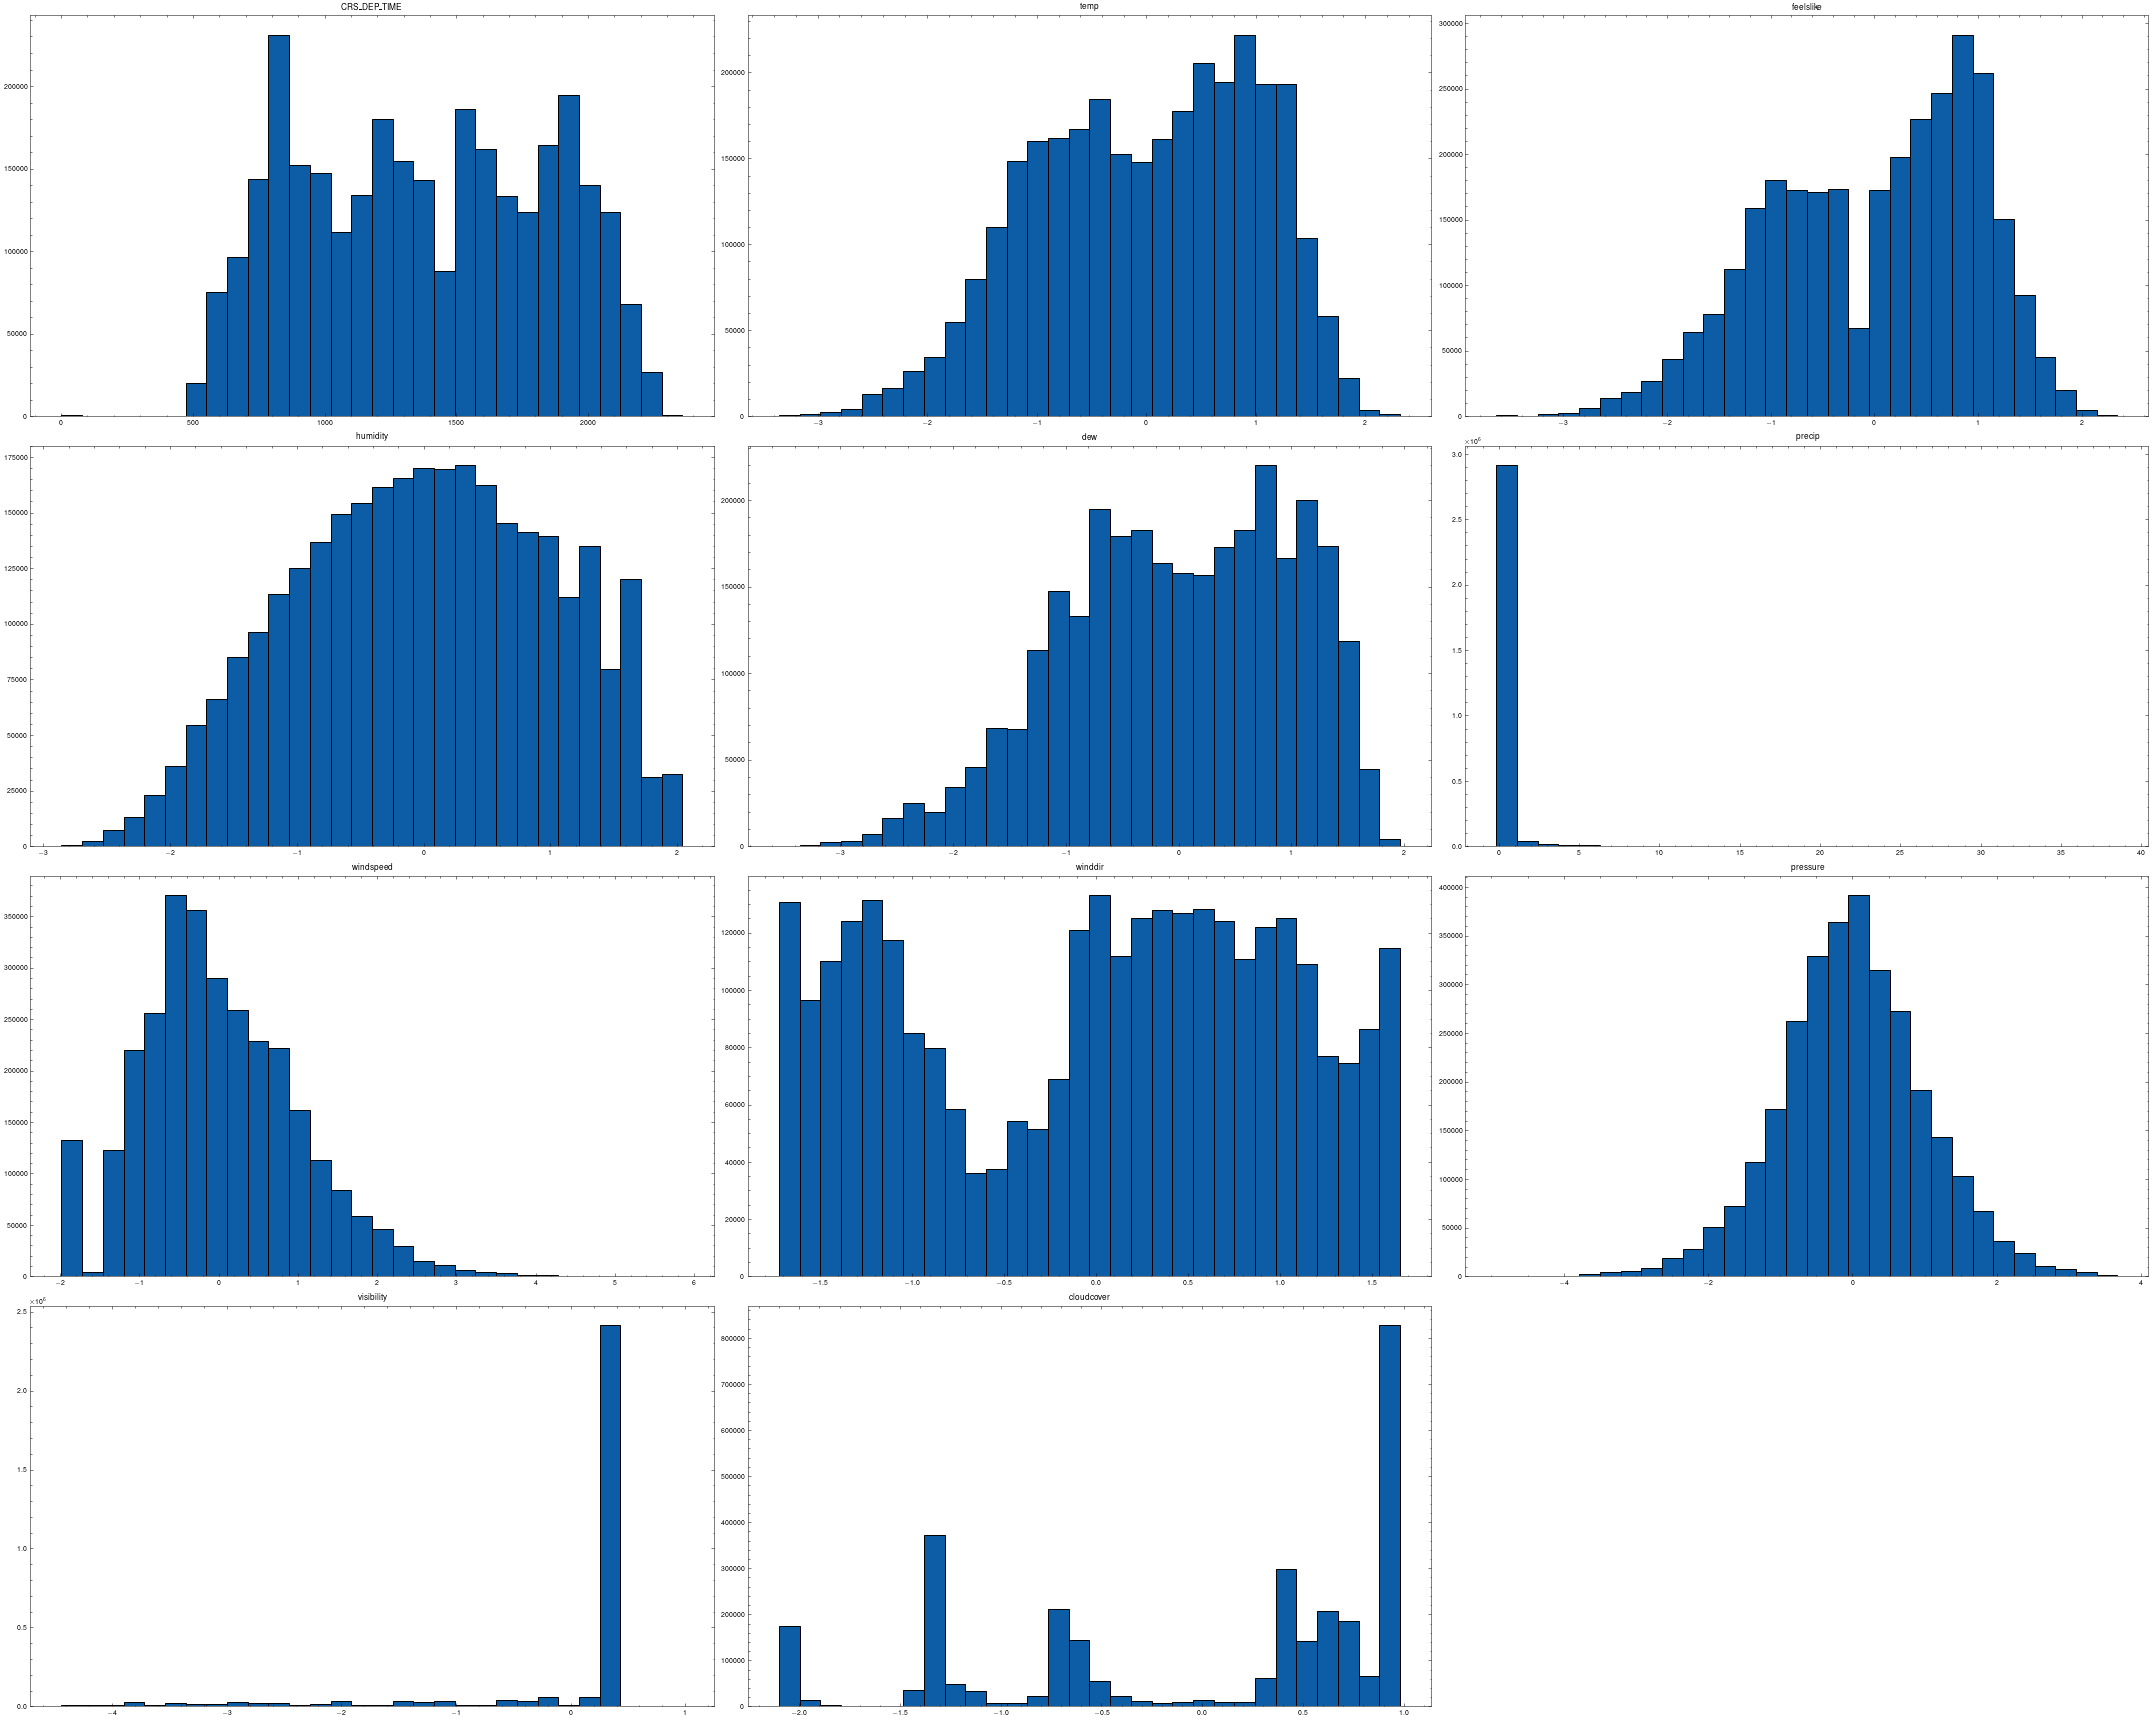

In [26]:
X.hist(column=['CRS_DEP_TIME', 'temp', 'feelslike', 'humidity', 'dew', 'precip', 'windspeed', 'winddir', 'pressure', 'visibility', 'cloudcover'], bins=30, grid=False, figsize=(30, 24), ec='k')
plt.tight_layout()
plt.show()


the precip looks like that because

In [27]:
df_norm.precip.describe()

count    3.001025e+06
mean     2.500256e-18
std      1.000000e+00
min     -1.479968e-01
25%     -1.479968e-01
50%     -1.479968e-01
75%     -1.479968e-01
max      3.852016e+01
Name: precip, dtype: float64

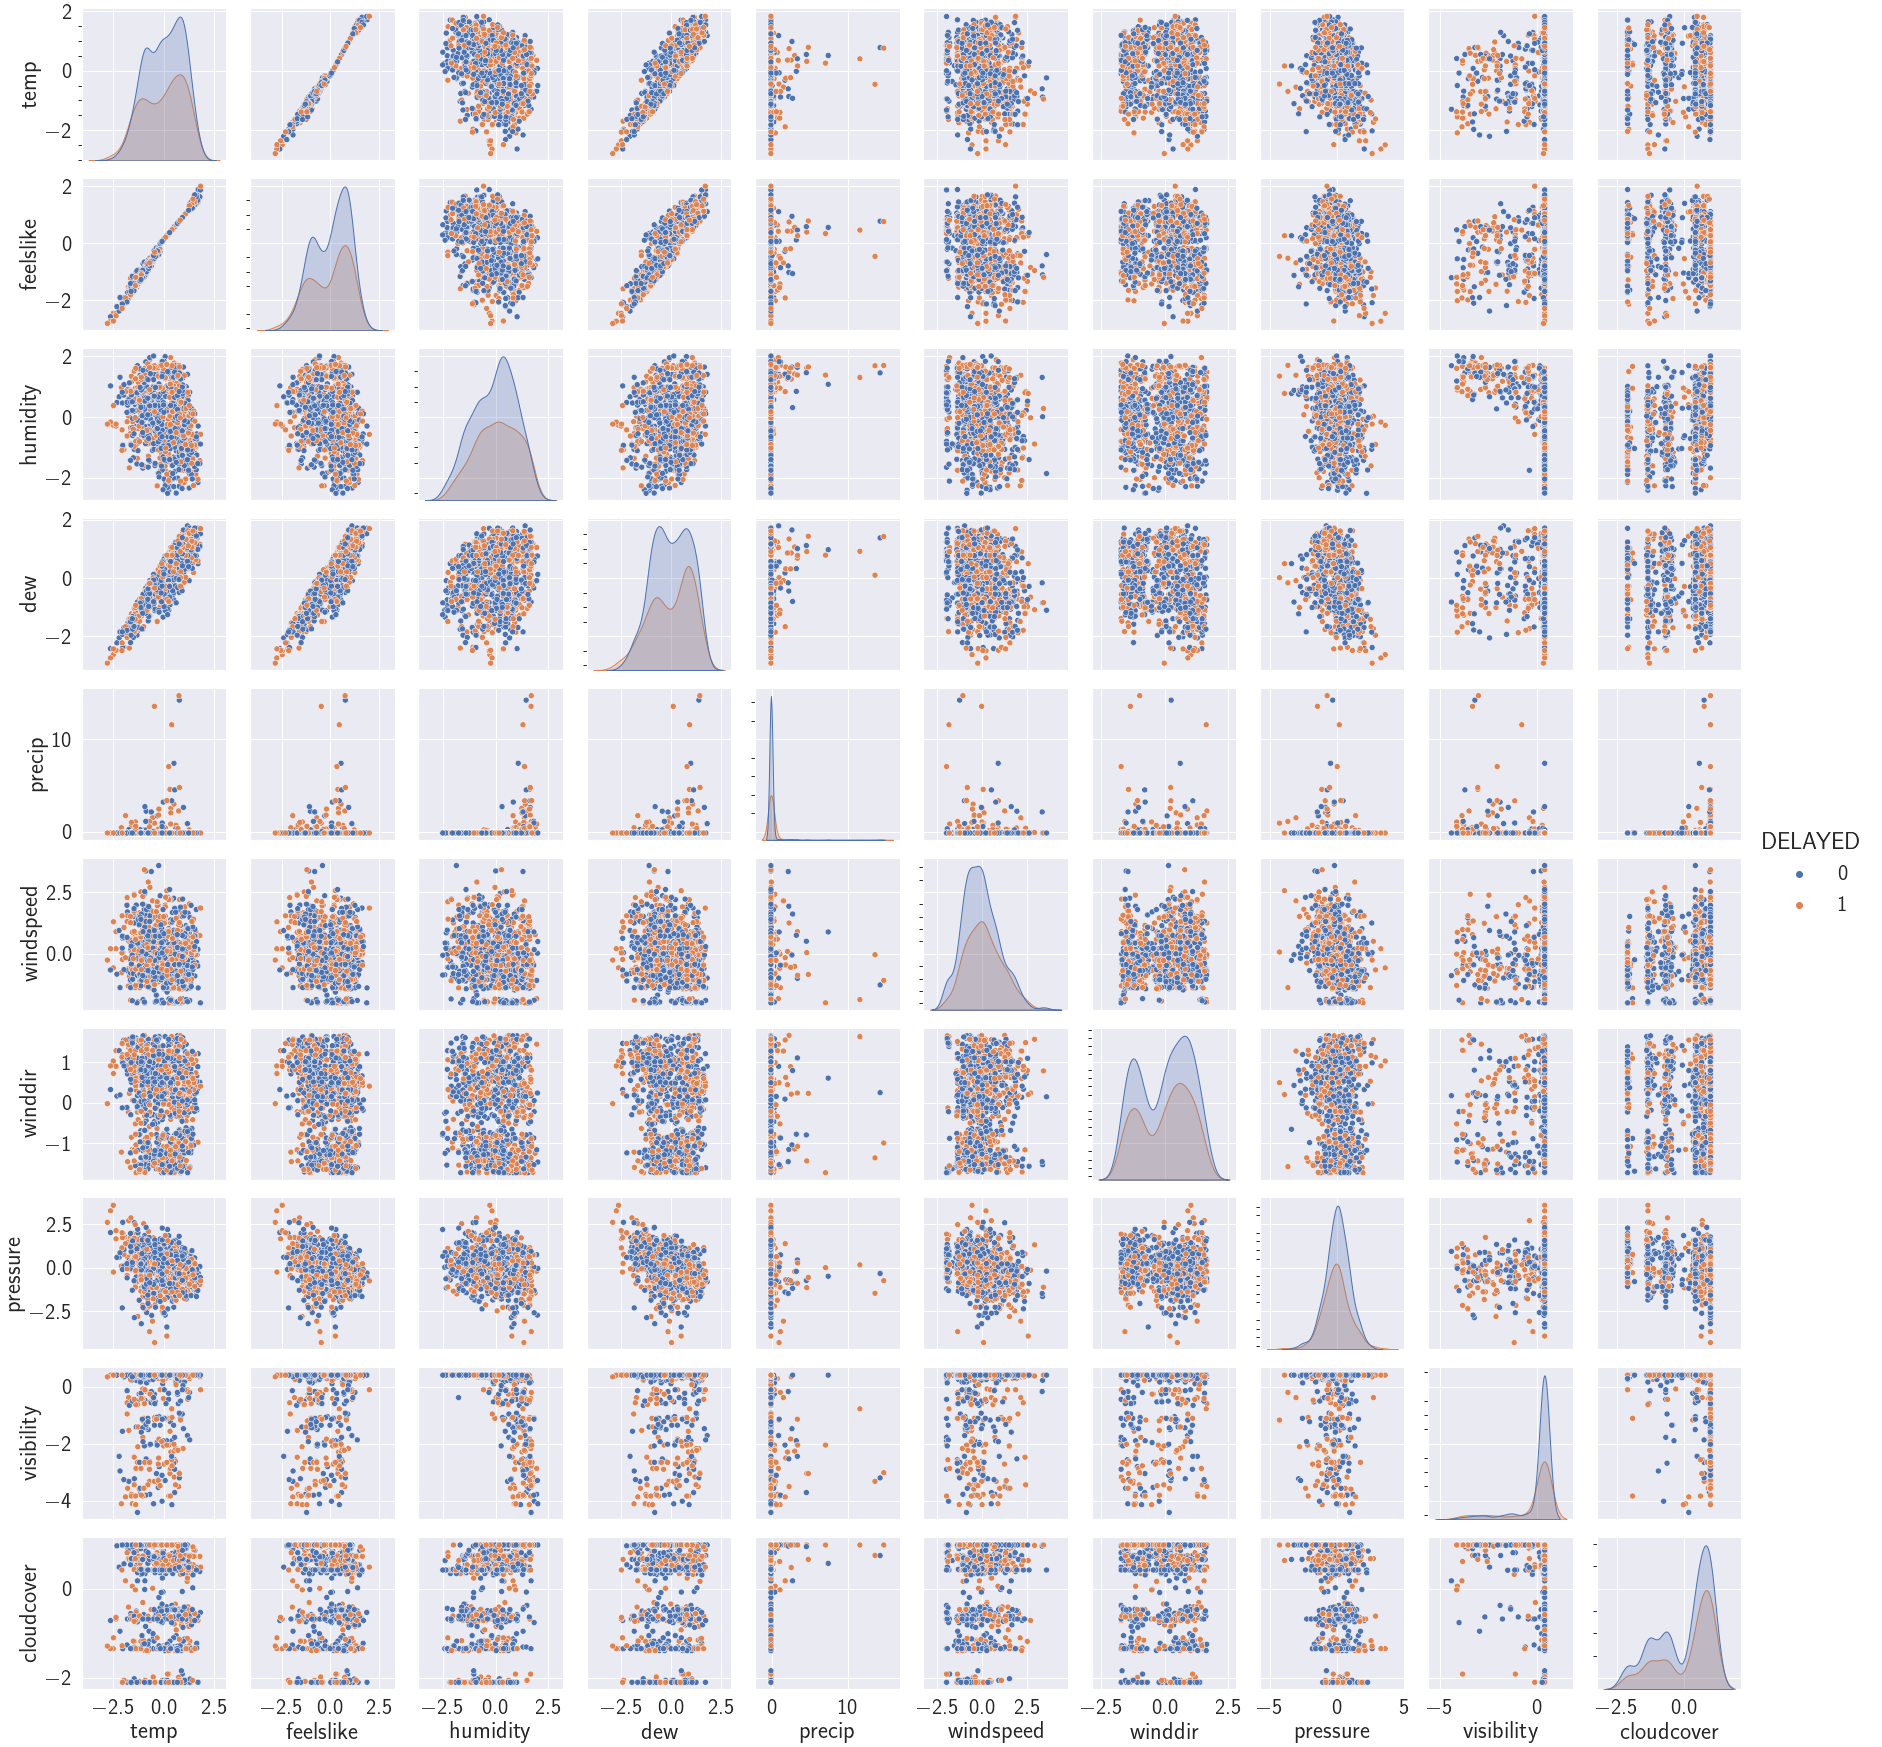

In [28]:
sns.set(font_scale = 2)
sns.pairplot(df_norm.sample(1000).loc[:, ['DELAYED', 'temp', 'feelslike', 'humidity', 'dew', 'precip', 'windspeed', 'winddir', 'pressure', 'visibility', 'cloudcover']], hue='DELAYED')

## set dummies

In [29]:
# get dummies
# dummy cols
dummies = ['OP_CARRIER', 'DEST', 'quarter', 'month', 'weekday', 'is_holiday', 'is_weekend']
X_w_dummies = pd.get_dummies(X, columns=dummies, drop_first=True)

X_w_dummies_train = X_w_dummies.loc[train_ix]
X_w_dummies_test = X_w_dummies.loc[test_ix]

X_w_dummies.head()

,CRS_DEP_TIME,temp,feelslike,humidity,dew,precip,windspeed,winddir,pressure,visibility,...,month_11,month_12,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,is_holiday_1,is_weekend_1
0,905.0,-1.511828,-1.684872,0.21766,-1.449729,-0.147997,1.270263,0.040878,0.584519,0.399819,...,0,0,0,0,1,0,0,0,1,0
1,910.0,-1.511828,-1.684872,0.21766,-1.449729,-0.147997,1.270263,0.040878,0.584519,0.399819,...,0,0,0,0,1,0,0,0,1,0
2,941.0,-1.511828,-1.684872,0.21766,-1.449729,-0.147997,1.270263,0.040878,0.584519,0.399819,...,0,0,0,0,1,0,0,0,1,0
3,920.0,-1.511828,-1.684872,0.21766,-1.449729,-0.147997,1.270263,0.040878,0.584519,0.399819,...,0,0,0,0,1,0,0,0,1,0
4,925.0,-1.511828,-1.684872,0.21766,-1.449729,-0.147997,1.270263,0.040878,0.584519,0.399819,...,0,0,0,0,1,0,0,0,1,0


## Linear Regression

even though we are doing prediction analysis, we might as well start with inference for delay time with a linear regression.

transform categoricals to dummies

In [30]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

linear_regression_full = sm.OLS(Y_delay_time_train, sm.add_constant(X_w_dummies_train)).fit()
linear_regression_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DEP_DELAY   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     543.5
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:35:01   Log-Likelihood:            -1.0611e+07
No. Observations:             2100717   AIC:                         2.122e+07
Df Residuals:                 2100480   BIC:                         2.122e+07
Df Model:                         236                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -10.6046      0.782    -13.553      0.000     -12.138      -9.071
CRS_DEP_TIME      0.0127   6.19e-05    204.358      0.000       0.013       0.013
temp             10.9772      0.482     22.780      0.000      10.033      11.922
feelslike       -10.0669      0.329    -30.552      0.000     -10.713      -9.421
humidity          4.4557      0.164     27.183      0.000       4.134       4.777
dew              -4.2957      0.372    -11.545      0.000      -5.025      -3.566
precip            2.4924      0.027     91.195      0.000       2.439       2.546
windspeed         1.5443      0.033     46.176      0.000       1.479       1.610
winddir           0.5472      0.028     19.477      0.000       0.492       0.602
pressure         -0.5834      0.034    -16.979      0.000      -0.651      -0.516
visibility       -2.3569      0.036    -65.646      0.000      -2.427      -2.286
cloudcover        1.0179      0.030     34.154      0.000       0.959       1.076
OP_CARRIER_AA    -3.9430      0.593     -6.646      0.000      -5.106      -2.780
OP_CARRIER_AS    -9.3490      0.704    -13.281      0.000     -10.729      -7.969
OP_CARRIER_B6     0.6793      0.662      1.026      0.305      -0.619       1.977
OP_CARRIER_CO    -3.0844      0.697     -4.425      0.000      -4.451      -1.718
OP_CARRIER_DL    -0.7755      0.620     -1.252      0.211      -1.990       0.439
OP_CARRIER_EV     2.6750      0.596      4.488      0.000       1.507       3.843
OP_CARRIER_F9     4.0302      0.699      5.769      0.000       2.661       5.399
OP_CARRIER_MQ    -2.9874      0.591     -5.054      0.000      -4.146      -1.829
OP_CARRIER_NK    -0.3523      0.635     -0.555      0.579      -1.597       0.893
OP_CARRIER_NW    -8.5360      0.852    -10.015      0.000     -10.206      -6.865
OP_CARRIER_OH     0.7832      0.777      1.007      0.314      -0.741       2.307
OP_CARRIER_OO     0.3506      0.593      0.591      0.555      -0.812       1.513
OP_CARRIER_UA    -1.6562      0.592     -2.795      0.005      -2.817      -0.495
OP_CARRIER_US    -7.2425      0.638    -11.347      0.000      -8.493      -5.992
OP_CARRIER_VX    -7.1467      0.754     -9.477      0.000      -8.625      -5.669
OP_CARRIER_XE     0.3755      0.612      0.614      0.539      -0.824       1.574
OP_CARRIER_YV     0.3777      0.613      0.616      0.538      -0.824       1.579
OP_CARRIER_YX    -5.4339      0.680     -7.997      0.000      -6.766      -4.102
DEST_ABQ          4.5364      0.742      6.116      0.000       3.083       5.990
DEST_ACY          2.5974      2.026      1.282      0.200      -1.374       6.569
DEST_AGS         -1.7569     12.608     -0.139      0.889     -26.467      22.954
DEST_ALB          3.6021      0.640      5.632      0.000       2.349       4.856
DEST_ALO         -0.5803      0.891     -0.651   

### Prediction

In [31]:
y_delay_time_predict = linear_regression_full.predict(sm.add_constant(X_w_dummies_test))
pred_error = Y_delay_time_test - y_delay_time_predict 
error_lr_full = np.sum(np.square(pred_error)) 
mse = error_lr_full / len(Y_delay_time_test)
rmse = np.sqrt(mse)
printmd(f'### MSE: {mse}\n### RMSE: {np.sqrt(mse)}')

### MSE: 1404.772259904254
### RMSE: 37.48029161978671

### Lasso Regression

In [32]:
from sklearn.linear_model import Lasso
linear_regression_full_LASSO = Lasso(random_state=42)
linear_regression_full_LASSO.fit(X_w_dummies_train.to_numpy(), Y_delay_time_train.to_numpy())

Lasso(random_state=42)

Lasso will select the most important features, and will set to 0 the others. Then we can see the ones that are important here

In [33]:
lasso_features = pd.DataFrame(linear_regression_full_LASSO.coef_, X_w_dummies_train.columns, columns=['coef']).sort_values(by='coef', ascending=False)
lasso_features[lasso_features['coef'] != 0]

,coef
precip,2.043500
humidity,1.986799
windspeed,0.649219
cloudcover,0.508710
CRS_DEP_TIME,0.011276
pressure,-0.348926
visibility,-1.769226


In [34]:
# predict for the test set
lasso_y_pred = linear_regression_full_LASSO.predict(X_w_dummies_test.to_numpy())

# calculate the error
pred_error = np.sum(np.square(Y_delay_time_test - lasso_y_pred))

# calculate the MSE
mse = pred_error / len(Y_delay_time_test)

# calculate the RMSE
np.sqrt(mse)

printmd(f'### MSE: {mse}\n### RMSE: {np.sqrt(mse)}')



### MSE: 1434.9139261382004
### RMSE: 37.880257735899846

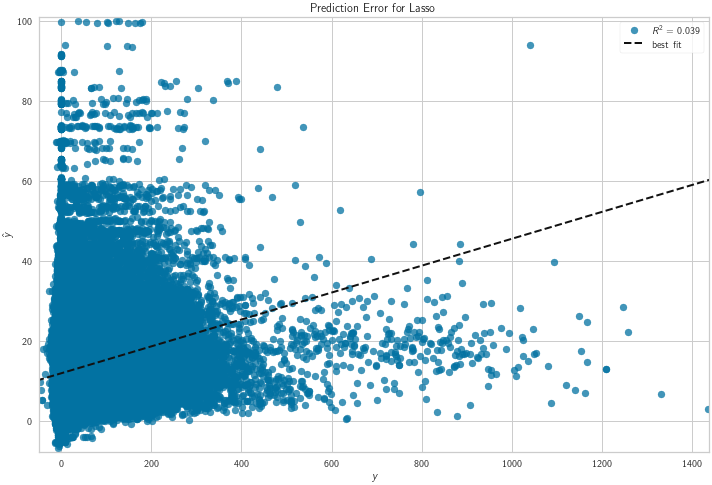

In [35]:
from yellowbrick.regressor import prediction_error
fig, ax = plt.subplots(figsize=(12, 8))
plt.ylim(0, 200)
visualizers = prediction_error(linear_regression_full_LASSO, X_w_dummies_train.to_numpy(), Y_delay_time_train.to_numpy(), X_w_dummies_test.to_numpy(), Y_delay_time_test.to_numpy(), identity=False, ax=ax, shared_limits=False, is_fitted=True)


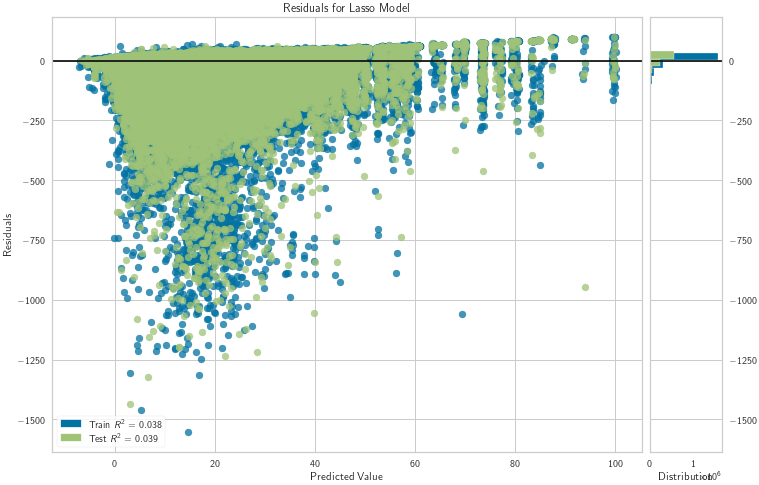

In [36]:
from yellowbrick.regressor import residuals_plot
fig, ax = plt.subplots(figsize=(12, 8))
vis_rp = residuals_plot(linear_regression_full_LASSO, X_w_dummies_train.to_numpy(), Y_delay_time_train.to_numpy(), X_w_dummies_test.to_numpy(), Y_delay_time_test.to_numpy(), identity=False, ax=ax, shared_limits=False, is_fitted=True)

In [37]:
df_cleaned.precip.dtypes

dtype('float64')

## AIC / BIC
### BIC

In [38]:
from sklearn.linear_model import LassoLarsIC

model_bic = LassoLarsIC(criterion='bic',  fit_intercept=True, verbose=100, normalize=False)
model_bic.fit(X_w_dummies_train.to_numpy(), Y_delay_time_train.to_numpy())

Step		Added		Dropped		Active set size		C
0		0				1		4495414096.688949
1		9				2		9436476.342734113
2		3				3		8858219.047268791
3		5				4		8139030.887024446
4		10				5		4495278.579011891
5		8				6		3724852.3138059387
6		6				7		3533906.212726786
7		4				8		1403382.8147874882
8		221				9		1370149.7111965253
9		18				10		1280336.9335963014
10		226				11		1069667.6331271227
11		7				12		1043507.2832505165
12		227				13		780688.4008450828
13		229				14		763198.3360763838
14		23				15		729073.1519518237
15		240				16		628305.8247348915
16		220				17		567957.2438241204
17				[4]		16		[566426.04055487]
18		236				17		482066.940084224
19		219				18		416123.8749936365
20		233				19		407436.0900178959
21		231				20		392034.15996032616
22		237				21		385461.4556095341
23		2				22		374171.35869821196
24		16				23		349825.93389556505
25		225				24		295334.44989938143
26		91				25		290461.7434234165
27		191				26		254282.05738688074
28		234				27		250191.47048057616
29		132				28		199853.16579399243

LassoLarsIC(criterion='bic', normalize=False, verbose=100)

In [51]:
bic_features = pd.DataFrame(model_bic.coef_, X_w_dummies_train.columns, columns=['coef'])
display(bic_features[bic_features['coef'] != 0])

,coef
CRS_DEP_TIME,0.012530
temp,9.812643
feelslike,-9.665620
humidity,4.107898
dew,-3.492425
precip,2.494147
windspeed,1.559622
winddir,0.545877
pressure,-0.580411
visibility,-2.386575


In [42]:
# predict for the test set
bic_y_pred = model_bic.predict(X_w_dummies_test.to_numpy())

# calculate the error
pred_error = np.sum(np.square(Y_delay_time_test - bic_y_pred))

# calculate the MSE
mse = pred_error / len(Y_delay_time_test)

# calculate the RMSE
np.sqrt(mse)

printmd(f'### MSE: {mse}\n### RMSE: {np.sqrt(mse)}')

### MSE: 1405.1523809137789
### RMSE: 37.48536222198978

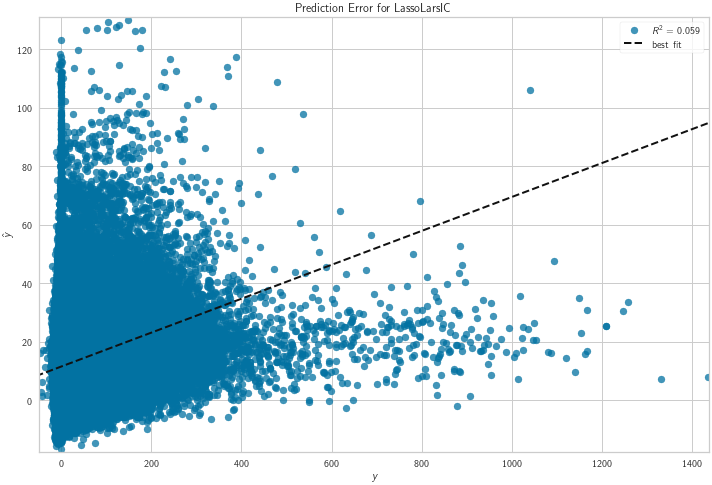

In [43]:
from yellowbrick.regressor import prediction_error
fig, ax = plt.subplots(figsize=(12, 8))
plt.ylim(0, 200)
visualizers = prediction_error(model_bic, X_w_dummies_train.to_numpy(), Y_delay_time_train.to_numpy(), X_w_dummies_test.to_numpy(), Y_delay_time_test.to_numpy(), identity=False, ax=ax, shared_limits=False, is_fitted=True)

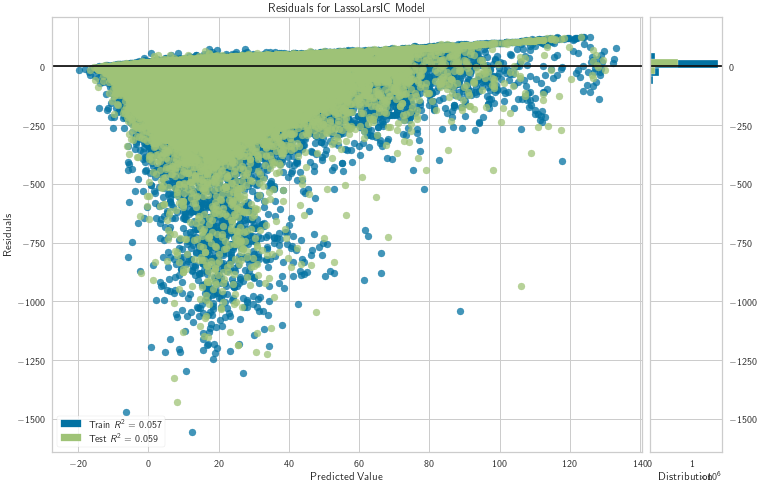

In [44]:
from yellowbrick.regressor import residuals_plot
fig, ax = plt.subplots(figsize=(12, 8))
vis_rp = residuals_plot(model_bic, X_w_dummies_train.to_numpy(), Y_delay_time_train.to_numpy(), X_w_dummies_test.to_numpy(), Y_delay_time_test.to_numpy(), identity=False, ax=ax, shared_limits=False, is_fitted=True)

### AIC

In [45]:

from sklearn.linear_model import LassoLarsIC

model_aic = LassoLarsIC(criterion='aic',  fit_intercept=True, verbose=100, normalize=False)
model_aic.fit(X_w_dummies_train.to_numpy(), Y_delay_time_train.to_numpy())

Step		Added		Dropped		Active set size		C
0		0				1		4495414096.688949
1		9				2		9436476.342734113
2		3				3		8858219.047268791
3		5				4		8139030.887024446
4		10				5		4495278.579011891
5		8				6		3724852.3138059387
6		6				7		3533906.212726786
7		4				8		1403382.8147874882
8		221				9		1370149.7111965253
9		18				10		1280336.9335963014
10		226				11		1069667.6331271227
11		7				12		1043507.2832505165
12		227				13		780688.4008450828
13		229				14		763198.3360763838
14		23				15		729073.1519518237
15		240				16		628305.8247348915
16		220				17		567957.2438241204
17				[4]		16		[566426.04055487]
18		236				17		482066.940084224
19		219				18		416123.8749936365
20		233				19		407436.0900178959
21		231				20		392034.15996032616
22		237				21		385461.4556095341
23		2				22		374171.35869821196
24		16				23		349825.93389556505
25		225				24		295334.44989938143
26		91				25		290461.7434234165
27		191				26		254282.05738688074
28		234				27		250191.47048057616
29		132				28		199853.16579399243

LassoLarsIC(normalize=False, verbose=100)

In [50]:
aic_features = pd.DataFrame(model_aic.coef_, X_w_dummies_train.columns, columns=['coef'])

pd.set_option('display.max_rows', 200)
display(aic_features[bic_features['coef'] != 0])

,coef
CRS_DEP_TIME,0.012648
temp,10.955811
feelslike,-10.059968
humidity,4.449037
dew,-4.280529
precip,2.492443
windspeed,1.544525
winddir,0.547179
pressure,-0.583326
visibility,-2.357440


In [52]:
# predict for the test set
aic_y_pred = model_aic.predict(X_w_dummies_test.to_numpy())

# calculate the error
pred_error = np.sum(np.square(Y_delay_time_test - aic_y_pred))

# calculate the MSE
mse = pred_error / len(Y_delay_time_test)

# calculate the RMSE
np.sqrt(mse)

printmd(f'### MSE: {mse}\n### RMSE: {np.sqrt(mse)}')

### MSE: 1404.7708115983353
### RMSE: 37.48027229888192

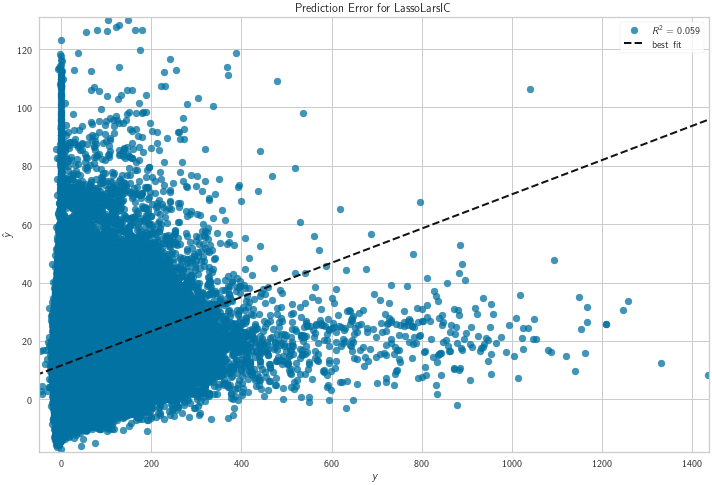

In [53]:
from yellowbrick.regressor import prediction_error
fig, ax = plt.subplots(figsize=(12, 8))
plt.ylim(0, 200)
visualizers = prediction_error(model_aic, X_w_dummies_train.to_numpy(), Y_delay_time_train.to_numpy(), X_w_dummies_test.to_numpy(), Y_delay_time_test.to_numpy(), identity=False, ax=ax, shared_limits=False, is_fitted=True)

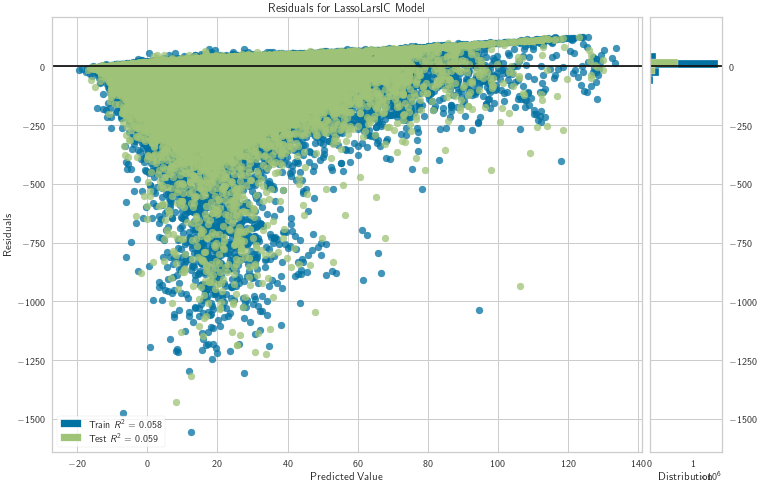

In [54]:
from yellowbrick.regressor import residuals_plot
fig, ax = plt.subplots(figsize=(12, 8))
vis_rp = residuals_plot(model_aic, X_w_dummies_train.to_numpy(), Y_delay_time_train.to_numpy(), X_w_dummies_test.to_numpy(), Y_delay_time_test.to_numpy(), identity=False, ax=ax, shared_limits=False, is_fitted=True)